```
This software is part of GPU Ocean. 

Copyright (C) 2017-2019 SINTEF Digital
Copyright (C) 2017-2019 Norwegian Meteorological Institute

This notebook implements the plotting of the Rossby adjustment test case, as 
reported under Case B in "Evaluation of Selected Finite-Difference 
and Finite-Volume Approaches to Rotational Shallow-Water Flow"
by Holm, Brodtkorb, Broström, Christensen and Sætra.

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.
```

# Plotting of Case B: Rossby Adjustment

This notebook is for creating informative figures for comparing different oceanographic properties between numerical schemes.
All data is expected to be read in from NetCDF files.

## This specific notebook intention:
Visualizing and plotting from the notebook from CaseB_RossbyAdjustment.ipynb

## How to use this notebook
This notebook is meaningless without existing result files. They can be obtained in two ways:
- Produce your own results by running the notebook CaseB_RossbyAdjustment.ipynb. Your results will be written to netCDF files in a folder containing a timestamp. In order to use those files in this notebook, **change the location of the result files in the cell that is reading data below**. This should be immediately under the heading "Read data and plot".
- Download the results that were presented in the paper from http://gpu-ocean.met.no:9000/python/netcdf_2018_01_24/, so that the default result file names in this notebook can be used.

## Producing the reference solution
The file `python/matlab/python_like_steady_state.m` contains code to produce the reference solution for Rossby adjustment. It is confirmed to work with Octave, and writes the reference solution to `python/matlab/KG.mat`. Comparison with the reference solution is created if this file exists.


#### Import modules and set up environment

In [1]:
#Lets have matplotlib "inline"
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

#Import packages we need
import numpy as np
from matplotlib import animation, rc
from matplotlib import pyplot as plt
from matplotlib import gridspec

import os
import datetime
import sys
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../../')))

import scipy.io
import os.path

from importlib import reload

#Set large figure sizes
rc('figure', figsize=(5.0, 4.0))
rc('animation', html='html5')

#Import our Simulation Reader
from gpuocean.SWEsimulators import CDKLM16
from gpuocean.utils import SimReader, PlotHelper, Common, WindStress
from gpuocean.utils.BathymetryAndICs import *



In [2]:
gpu_ctx = Common.CUDAContext()

### Define the different functions for evaluating some of the properties to be plotted.

In [3]:
"""
Returns d/dx(0.5*g*h*h) + fhv
"""
def geostrophicBalanceEta(eta, H, hu, hv, nx, ny, dx, dy, f, g):
    return geostrophicBalance(eta+H, hu, hv, nx, ny, dx, dy, f, g)

def geostrophicBalance(h, hu, hv, nx, ny, dx, dy, f, g):
    # Expect 0 ghost cells in input arrays
    A = hu*hv/h
    B = hu*hu/h
    C = 0.5*g*h*h
    D = -f*hv
    
    Ay = np.zeros_like(A)
    Bx = np.zeros_like(B)
    Cx = np.zeros_like(C)
    
    Ay[1:-1,:] = (A[:-2,:] - A[2:,:])/(2*dy)
    Bx[:, 1:-1] = (B[:,:-2] - B[:,2:])/(2*dx)
    Cx[:, 1:-1] = (C[:,:-2] - C[:,2:])/(2*dx)
    
    #geoBalance = (Cx )/D - 1
    geoBalance = Cx - D
    #geoBalance = (Ay + Bx + Cx )/D - 1
    #geoBalance = (Ay + Bx + Cx - D)/(0.5*(Ay + Bx + Cx + D))
    return geoBalance

def geostrophicBalanceStaggered(eta, H, hu_s, hv_s, nx, ny, dx, dy, f, g):
    # Expect 0 ghost cells only
       
    h = eta + H
    hu = 0.5*(hu_s[:, :-1] + hu_s[:, 1:])
    hv = 0.5*(hv_s[:-1, :] + hv_s[1:, :])
    return geostrophicBalance(h, hu, hv, nx, ny, dx, dy, f, g )


def kleinGordonBalance(eta, H, eta_0, nx, ny, dx, dy, f, g):
    # Expect 0 ghost cells only
    c = np.sqrt(g*H)
    a = c/f
    constant = 1/(a*a)
    print("a: , const: ", a, constant)
    print("dx, dy:", dx, dy)
    print("max eta-eta_0: ", np.max(eta - eta_0))
    
    eta_xx = np.zeros_like(eta)
    eta_yy = np.zeros_like(eta)
    laplace_eta = np.zeros_like(eta) 
        
    eta_yy[1:-1, :] = (eta[:-2,:] -2*eta[1:-1,:] + eta[2:, :])/(dy*dy)
    eta_xx[:, 1:-1] = (eta[:, :-2] - 2*eta[:, 1:-1] + eta[:, 2:])/(dx*dx)
    laplace_eta = eta_xx + eta_yy
    print("max Laplacean: ", np.max(laplace_eta))
    
    kg = laplace_eta - constant*(eta - eta_0)
    return kg
    
    

### Parameters used 

Changed:
- g 
> 9.81 -> 0.1
- dx, dy 
> 50,000 -> 5,000
- depth (more shallow depths make problems)
> 1000 -> 50

In [4]:
# Common parameters from Kai

nx = 800
ny = 1000

dx = 5000
dy = 5000

dt = 100
g = 0.1
f = 1.2e-4
r = 0.0
H0 = 50.0
A = 0.0 # A is diffusion coefficient multiplied by depth.

wind = WindStress.WindStress()

# Using an open boundary
sponge = {"north":10, "east":10, "south":10, "west":10}
boundaryConditions = Common.BoundaryConditions(3,3,3,3, spongeCells=sponge)

ghosts = [2, 2, 2, 2]
dataShape = (ny + ghosts[0]+ghosts[2], 
             nx + ghosts[1]+ghosts[3])
validDomain =  [10, 10, 10, 10]
cutoff = 10


# Rossby adjustment parameters:
c0_squared = g*H0
a_squared = g*H0/(f*f)

T_steady_state = np.pi/f
print (T_steady_state)

#T = 300#sub_T = 4000.0

T = 38
sub_T = 300*dt
make_netCDF = True
def get_sub_T(i):
    if i < 21:
        return sub_T
    else:
        return sub_T*40

totSimTime = 0
for i in range(T):
    totSimTime = totSimTime + get_sub_T(i)
print ("Tot sim time: ", totSimTime-sub_T)

interestingDomain = 250

paramSet = "Kai"
msg = "Using variables from " + paramSet

# For plotting:
#Calculate radius from center of bump for plotting
x_center = dx*nx/2.0
y_center = dy*ny/2.0
y_coords, x_coords = np.mgrid[0:ny*dy:dy, 0:nx*dx:dx]
x_coords = np.subtract(x_coords, x_center)
y_coords = np.subtract(y_coords, y_center)
radius = np.sqrt(np.multiply(x_coords, x_coords) + np.multiply(y_coords, y_coords))

# Domain for imshow
domain_extent = [ 0, dx*nx*1e-6, 0, dy*ny*1e-6 ]
xlabel = "$x$ ($10^6$ m)"
ylabel = "$y$ ($10^6$ m)"
labelfont = 13

26179.93877991494
Tot sim time:  21000000


In [5]:
def initialConditions(eta0, nx, ny, dx, dy, halo_x, halo_y):
    print ("Making initial conditions")
    x_center = dx*nx/2.0
    y_center = dy*ny/2.0
    y_center1 = dy*(ny-100)/2.0
    y_center2 = dy*(ny+100)/2.0

    for j in range(-halo_y, ny+halo_y):
        for i in range(-halo_x, nx+halo_x):
            x = dx*i - x_center 
            y = dy*j - y_center 
            y1 = dy*j - y_center1
            y2 = dy*j - y_center2

            # Initial smooth step
            inirad = np.sqrt(x**2 + y**2)
            L = 15*dx
            D = 50*dx
            etaamp = 0.2
            
            # Add the the initial condition to the provided array
            #eta0[j+1, i+1] += 0.5*etaamp*(1.0+np.tanh((-inirad+D)/L))
            eta0[j+halo_y, i+halo_x] += 0.5*etaamp*(1.0+np.tanh((-inirad+D)/L))
            

In [6]:
#Coriolis well balanced reconstruction scheme

cdklm_eta0 = np.zeros(dataShape, dtype=np.float32, order='C');
cdklm_u0   = np.zeros(dataShape, dtype=np.float32, order='C');
cdklm_v0   = np.zeros(dataShape, dtype=np.float32, order='C');

# Bathymetry:
Hi = np.ones((dataShape[0]+1, dataShape[1]+1), dtype=np.float32, order='C')*H0
#linearBathymetryY(Bi, nx, ny, dx, dy, ghosts, 5, 50)

initialConditions(cdklm_eta0, nx, ny, dx, dy, ghosts[1], ghosts[0])

#Initialize simulator
if 'cdklm_sim' in globals():
    cdklm_sim.cleanUp()
reload(CDKLM16)
cdklm_sim = CDKLM16.CDKLM16(gpu_ctx, \
                            cdklm_eta0, cdklm_u0, cdklm_v0, \
                            Hi, \
                            nx, ny, \
                            dx, dy, dt, \
                            g, f, r, \
                            wind_stress=wind, \
                            boundary_conditions=boundaryConditions, \
                            reportGeostrophicEquilibrium=False, \
                            write_netcdf=make_netCDF)


Making initial conditions


In [7]:
for i in range(T):
    t = cdklm_sim.step(get_sub_T(i))

## Read data and plot

In [8]:
imgdir='images_rossby_adjustment_' + datetime.datetime.now().strftime("%Y_%m_%d-%H_%M_%S")
os.makedirs(imgdir)
imgdir = imgdir + "/"

cdklm_sim = SimReader.SimNetCDFReader(cdklm_sim.sim_writer.output_file_name)


Closing file /home/florianb/havvarsel/reduced-gravity-ocean-model/notebooks/netcdf_2022_06_30/CDKLM16_2022_06_30-15_07_20.nc ...


t_end_cdklm 21030000.0
a: , const:  18633.899812498246 2.88e-09
dx, dy: 5000 5000
max eta-eta_0:  0.006488465
max Laplacean:  3.4245853e-10
images_rossby_adjustment_2022_06_30-15_08_32/


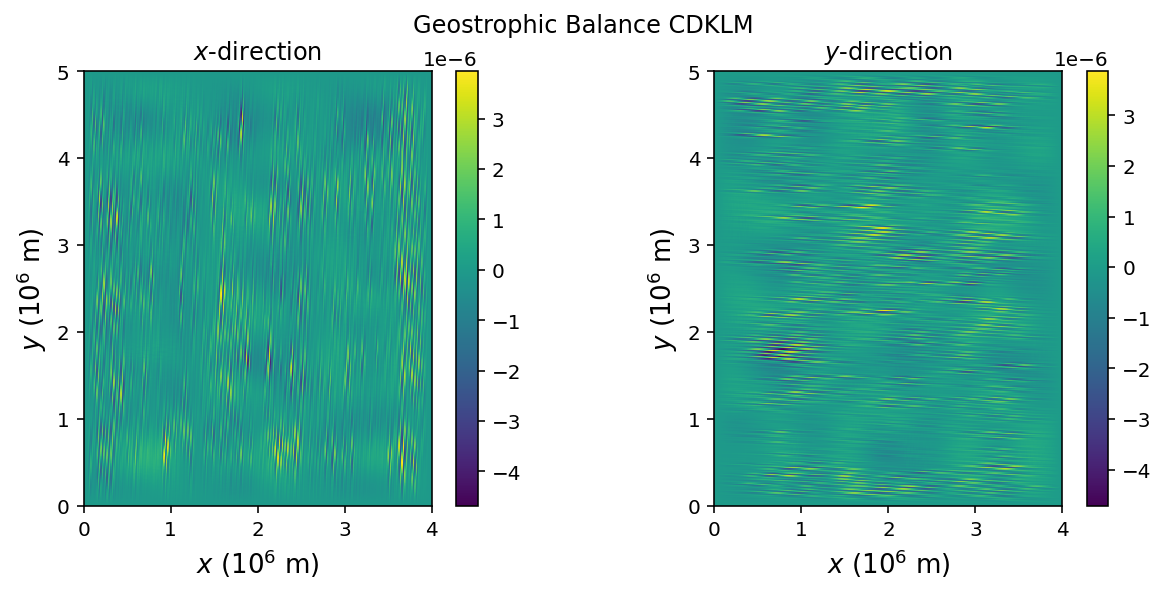

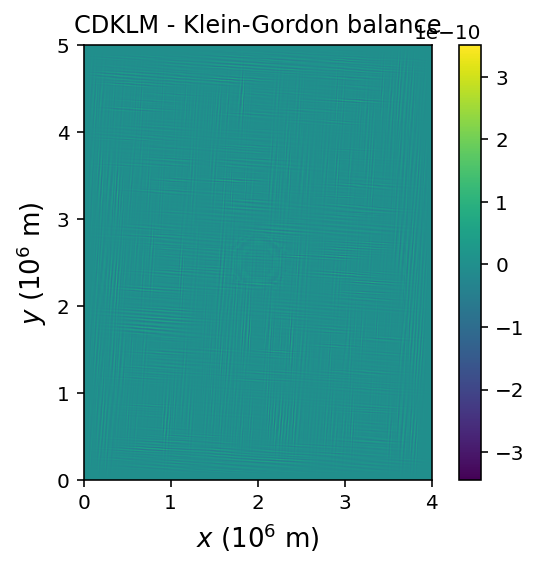

In [9]:
cdklm_eta, cdklm_hu, cdklm_hv, t_end_cdklm = cdklm_sim.getLastTimeStep()
cdklm_eta0, t_start = cdklm_sim.getEtaAtTimeStep(0)
print("t_end_cdklm", t_end_cdklm)

fig = plt.figure(figsize=(10, 4))
plt.subplot(1,2,1)    
gb_CDKLM = geostrophicBalanceEta(cdklm_eta, \
                                 H0, \
                                 cdklm_hu, \
                                 cdklm_hv, \
                                 nx, ny, \
                                 dx, dy, \
                                 f, g)
plt.imshow(gb_CDKLM, interpolation="none", origin='lower', extent=domain_extent)#, vmin=-1, vmax =1)
plt.title("$x$-direction")
plt.xlabel(xlabel, fontsize=labelfont)
plt.ylabel(ylabel, fontsize=labelfont)
plt.colorbar()

plt.subplot(1,2,2)
gb_CDKLM2 = geostrophicBalanceEta(cdklm_eta.T, \
                                  H0, \
                                  cdklm_hv.T, \
                                  cdklm_hu.T, \
                                  nx, ny, \
                                  dx, dy, \
                                  -f, g)
plt.imshow(gb_CDKLM2.T, interpolation="none", origin='lower', extent=domain_extent)#, vmin=-1, vmax =1)
plt.title("$y$-direction")
plt.xlabel(xlabel, fontsize=labelfont)
plt.ylabel(ylabel, fontsize=labelfont)
plt.colorbar()
plt.subplots_adjust(wspace=.3)
plt.suptitle("Geostrophic Balance CDKLM", fontsize=12)
fig.savefig(imgdir + "geoBalance_CDKLM_res.png")


fig = plt.figure(figsize=(5, 4))
KG_CDKLM = kleinGordonBalance(cdklm_eta, H0, \
                              cdklm_eta0, \
                              nx, ny, \
                              dx, dy, \
                              f, g)
plt.imshow(KG_CDKLM, origin='lower', extent=domain_extent)
plt.title("CDKLM - Klein-Gordon balance")
plt.xlabel(xlabel, fontsize=labelfont)
plt.ylabel(ylabel, fontsize=labelfont)
plt.colorbar()
fig.savefig(imgdir + "kleinGordon_CDKLM_res.png")

print(imgdir)

## Comparing final bump
Require the above cells to have been executed.

In [10]:
## Read analytic solution
analytic_solution_file_name = "matlab/KG.mat"
analytic_solution_exists = False
if os.path.isfile(analytic_solution_file_name):
    analytic_solution = scipy.io.loadmat(analytic_solution_file_name)
    analytic_solution_exists = True
    print(type(ctcs_eta0))
    print("------------------")
    print(type(analytic_solution))
    for key, val in analytic_solution.items():
        print(key, ": ", type(val))
        if str(type(val)) == "<type 'numpy.ndarray'>":
            print("\t\t", val.shape)
    print("-------------------------")
    
    # x (and y) is in the matlab file defined as  x=((1:Nx)-(Nx-1)/2)*dx
    # so we have to modified it according to the axis in our simulators
    
    analytic_eta      = analytic_solution['h']
    analytic_eta_init = analytic_solution['s']
    analytic_x        = analytic_solution['x'] # + (nx)*dx/2
    analytic_y        = analytic_solution['y'] # + (ny)*dy/2
    
    
    print(cdklm_eta.shape)
    print(analytic_eta.shape, analytic_eta_init.shape, analytic_x.shape, analytic_y.shape)
    
    xaxis, yaxis = cdklm_sim.getAxis()
    
    print("Comparing axis:")
    print(xaxis.shape, yaxis.shape)
    print(xaxis[234], analytic_x[0,234], xaxis[234] - analytic_x[0,234], dx/2)
    print(yaxis[234], analytic_y[0,234], yaxis[234] - analytic_y[0,234])
    print(xaxis[0], dx)
    
    
    fig = plt.figure(figsize=(5,5))
    plt.imshow(cdklm_eta - np.transpose(analytic_eta), origin="lower", extent=domain_extent)
    plt.colorbar()    
    plt.xlabel(xlabel, fontsize=labelfont)
    plt.ylabel(ylabel, fontsize=labelfont)


0
800
400
300
500
(1000, 800)
1.0070292


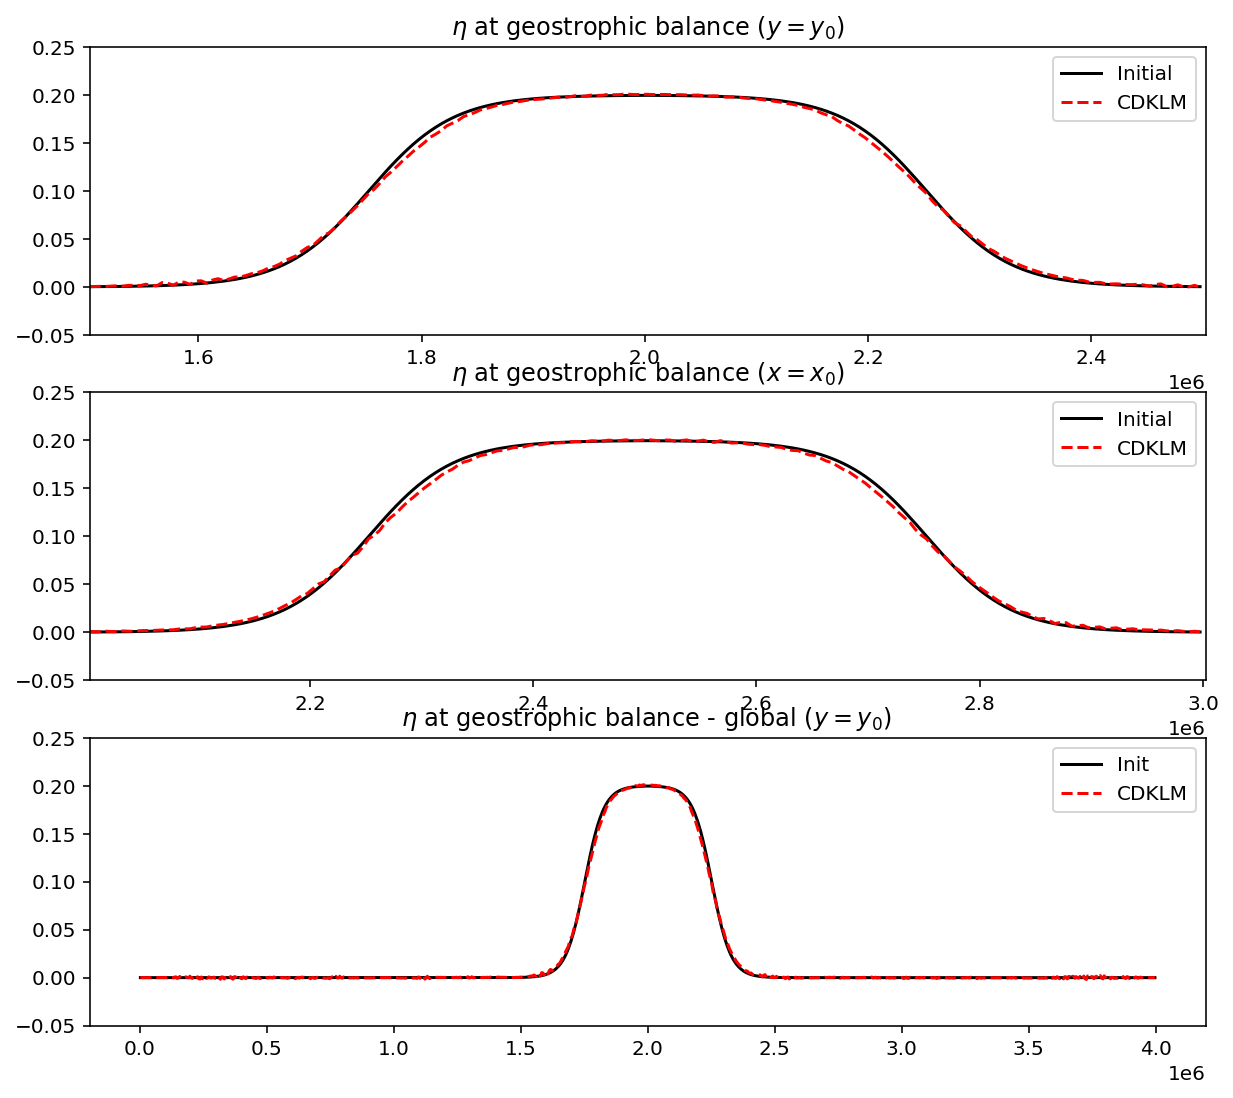

In [11]:
# Comparison of bump across the different methods:
cutoff = 0
midx = int((nx+2*cutoff)/2)
midy = int((ny+2*cutoff)/2)

# From above:
#interestingDomain = 250
#print cutoff
interestingDomain = int(100)
xaxis, yaxis = cdklm_sim.getAxis()

print(cutoff)
print(nx)
print(midx)
print(midx-interestingDomain)
print(midx+interestingDomain)
print(cdklm_eta.shape)

fig = plt.figure(figsize=(10, 9))
plt.subplot(3,1,1)
plt.title("$\eta$ at geostrophic balance ($y=y_0$)")
plt.plot(xaxis[midx-interestingDomain:midx+interestingDomain], cdklm_eta0[midy, midx-interestingDomain:midx+interestingDomain], 'k', label="Initial")
plt.plot(xaxis[midx-interestingDomain:midx+interestingDomain], cdklm_eta[midy, midx-interestingDomain:midx+interestingDomain], 'r--', label="CDKLM")
plt.xlim(xaxis[midx-interestingDomain], xaxis[midx+interestingDomain])
plt.ylim((-0.05, 0.25))
plt.legend()

#fig = plt.figure(figsize=(10, 9))
plt.subplot(3,1,2)
plt.title("$\eta$ at geostrophic balance ($x=x_0$)")
plt.plot(yaxis[midy-interestingDomain:midy+interestingDomain], cdklm_eta0[midy-interestingDomain:midy+interestingDomain, midx], 'k', label="Initial")
plt.plot(yaxis[midy-interestingDomain:midy+interestingDomain], cdklm_eta[midy-interestingDomain:midy+interestingDomain, midx], 'r--', label="CDKLM")
plt.xlim((yaxis[midy-interestingDomain], yaxis[midy+interestingDomain]))
plt.ylim((-0.05, 0.25))
plt.legend()

plt.subplot(3,1,3)
plt.title("$\eta$ at geostrophic balance - global ($y=y_0$) ")
plt.plot(xaxis, cdklm_eta0[midy, :], 'k', label="Init")
plt.plot(xaxis, cdklm_eta[midy, :], 'r--', label="CDKLM")
plt.ylim((-0.05, 0.25))
plt.legend()

fig.savefig(imgdir + "rossby_adjustment_x_and_y.png")
fig.savefig(imgdir + "rossby_adjustment_x_and_y.pdf")


print (np.max(cdklm_eta)/np.max(cdklm_eta0))



(1000, 800)
(1000, 800)
(1000,)
should be zero:  0.0
should be zero:  0.0
{min|max}{x|y}: -1997500.0 1997500.0 -2497500.0 2497500.0


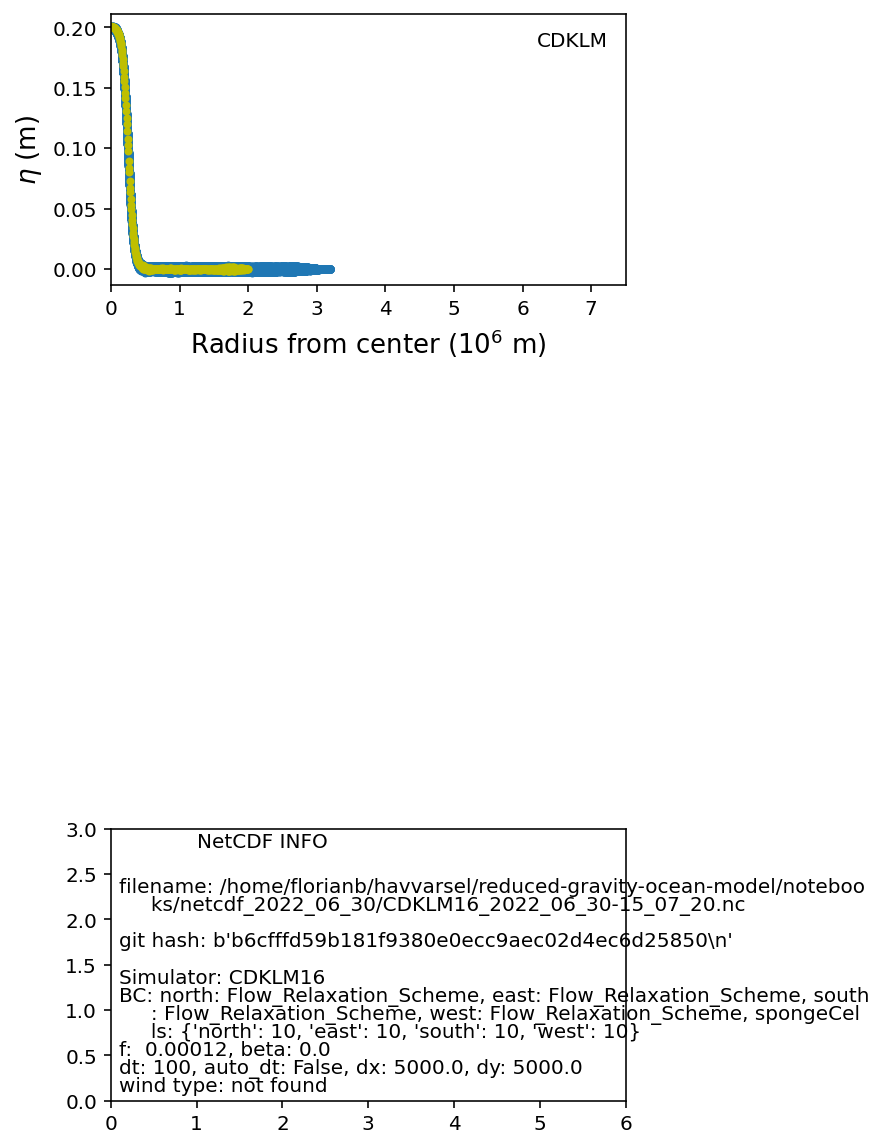

In [12]:
## Investigate radial symmetry


y_coords, x_coords = np.mgrid[dy/2.0:(ny+0.5)*dy:dy, dx/2.0:(nx+0.5)*dx:dx]
x_center = dx*nx/2.0
y_center = dy*ny/2.0

print(x_coords.shape)
print(y_coords.shape)
print(y_coords[:,4].shape)
print("should be zero: ", (y_coords[:, 346] - yaxis)[5])
print("should be zero: ", (x_coords[346, :] - xaxis)[5])

x_coords = np.subtract(x_coords, x_center)
y_coords = np.subtract(y_coords, y_center)
radius = np.sqrt(np.multiply(x_coords, x_coords) + np.multiply(y_coords, y_coords))
min_x = np.min(x_coords[:,0]);
min_y = np.min(y_coords[0,:]);

max_x = np.max(x_coords[0,:]);
max_y = np.max(y_coords[:,0]);
print("{min|max}{x|y}:",  min_x, max_x, min_y, max_y)

def plotRadialSymmetry(ax, eta, leg):
    sp_radial1, = ax.plot(radius.ravel()*1e-6, eta.ravel(), '.')#, label=leg)
    sp_radial1, = ax.plot(xaxis[0:int(nx/2)]*1e-6, eta[int(ny/2), int(nx/2):], '.y')
    sp_radial1.set_rasterized(True)
    invisible = ax.plot([], [], 'w', label=leg)
    #plt.axis([0, min(max_x, max_y), 59.96, 60.08])
    #plt.title(title)
    plt.xlabel("Radius from center ($10^6$ m)", fontsize=labelfont)
    plt.ylabel("$\eta$ (m)", fontsize=labelfont)
    plt.xlim(0, 7.5)
    plt.legend(loc=1, frameon=False)
    
    
allSims = [cdklm_sim]
allEtas = [cdklm_eta]
#allTitles = ["FBL radial symmetry", "CTCS radial symmetry", "KP radial symmetry", "CDKLM radial symmetry"]
allLegends = ["CDKLM"]
fig = plt.figure(figsize=(10, 22)) 
gs = gridspec.GridSpec(8,2)
for i in range(1):
    ax0 = plt.subplot(gs[i])
    plotRadialSymmetry(ax0, allEtas[i], allLegends[i])
    ax1 = plt.subplot(gs[4 + i*2])    
    allSims[i].makeInfoPlot(ax1, text_font_size=10)

fig.tight_layout()
fig.subplots_adjust(hspace=.5)
fig.savefig(imgdir + "rossby_adjustment_radial_symmetry.png")
fig.savefig(imgdir + "rossby_adjustment_radial_symmetry_dpi600.png", dpi=600)
fig.savefig(imgdir + "rossby_adjustment_radial_symmetry.pdf")



In [13]:
print (imgdir)


images_rossby_adjustment_2022_06_30-15_08_32/


## CDKLM artifact

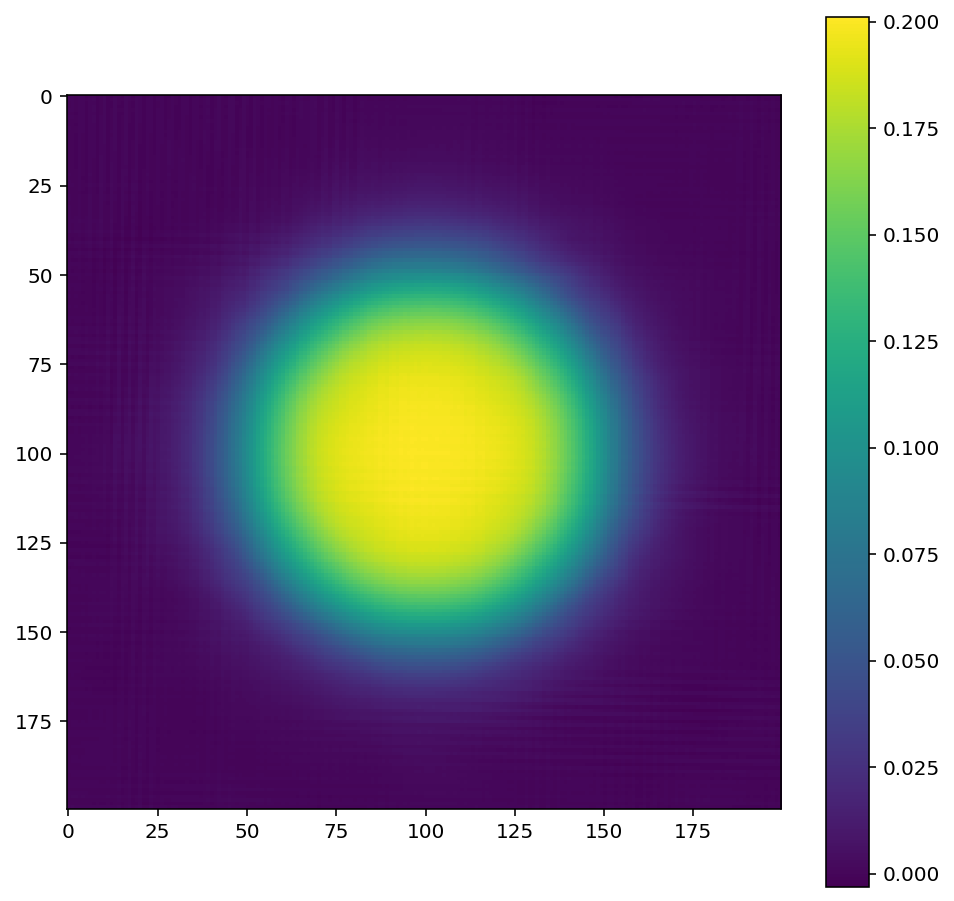

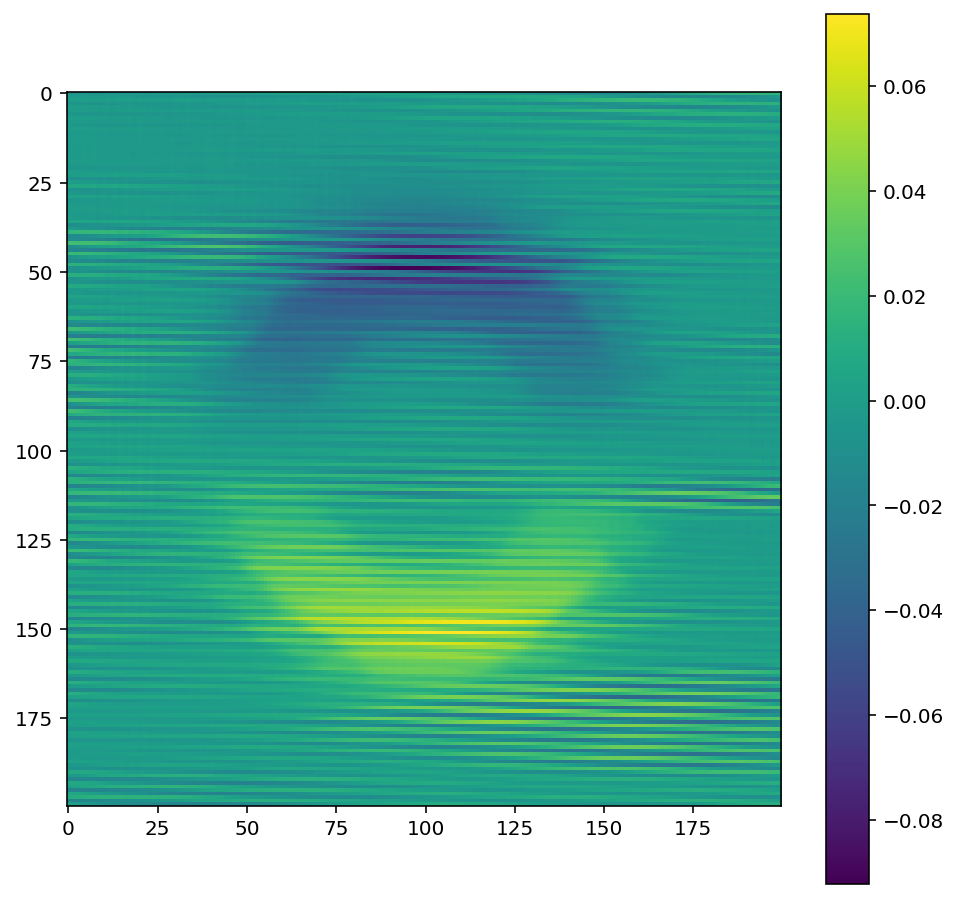

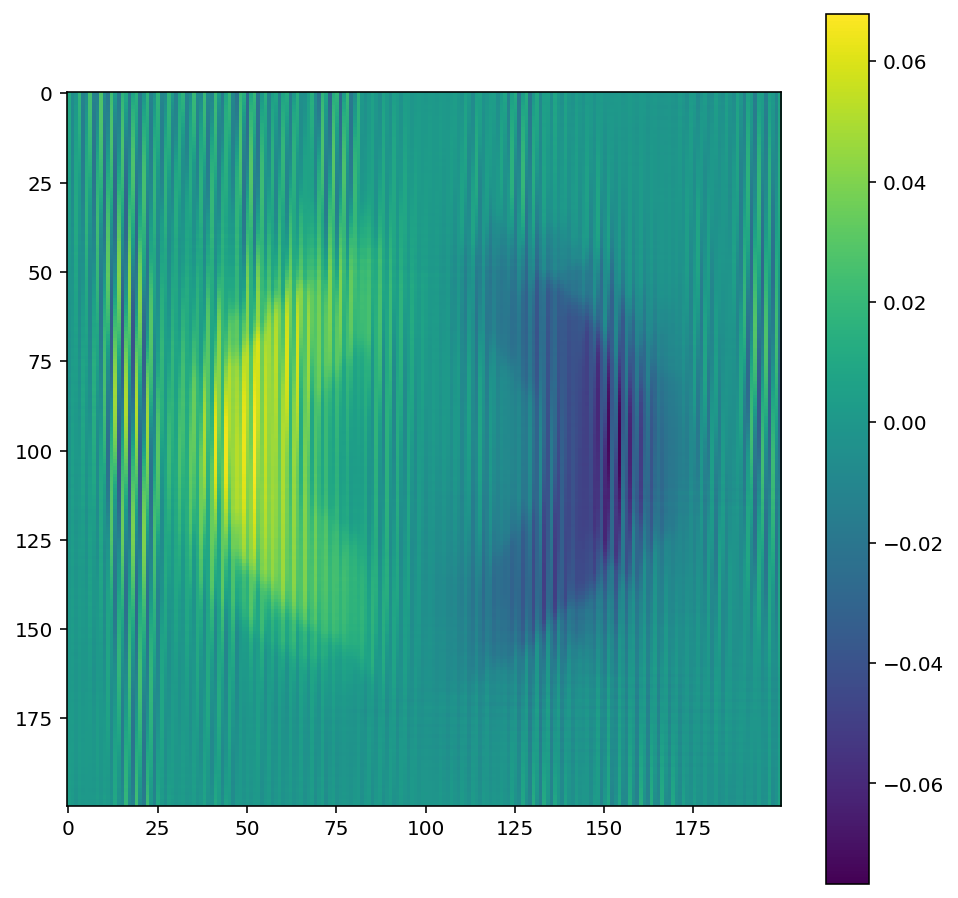

In [14]:
cdklm_eta, cdklm_hu, cdklm_hv, t_end_cdklm = cdklm_sim.getLastTimeStep()

#plt.imshow(cdklm_eta)
#plt.colorbar()

fig = plt.figure(figsize=(8,8))
plt.imshow(cdklm_eta[midy-interestingDomain:midy+interestingDomain, midx-interestingDomain:midx+interestingDomain])
plt.colorbar()

fig = plt.figure(figsize=(8,8))
plt.imshow(cdklm_hu[midy-interestingDomain:midy+interestingDomain, midx-interestingDomain:midx+interestingDomain])
plt.colorbar()

fig = plt.figure(figsize=(8,8))
plt.imshow(cdklm_hv[midy-interestingDomain:midy+interestingDomain, midx-interestingDomain:midx+interestingDomain])
plt.colorbar()
